Notes:
W103.388 to W103.028

N47.8548 to N47.755


To do
     - stitch raster’s together
	•	use buffer around points to cut out raster images of well sites to make y=1 values
    -  make make cutouts of other imagees for y = 0 values - keeping them all the same size
	•	split into training and dev sites
    - train algorithm with just one band
-  take new images and cut them up with standard sizing and use a steping window to perform detection

In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
from rasterio.merge import merge
from shapely.geometry import Point
import geopandas as gpd
from rasterio.plot import show

In [45]:
#import the images

satdat_list = []
for  i in range(1,10):
    im_temp = '/Users/dustin/CS/Projects/Well_identification/Images/S2B_MSIL1C_20190606T174919_N0207_R141_T13UFP_20190606T194941.SAFE/GRANULE/L1C_T13UFP_A011750_20190606T174937/IMG_DATA/T13UFP_20190606T174919_B0'+str(i)+'.jp2'
    satdat = rst.open(im_temp)
    satdat_list.append(satdat)
    
for  i in range(1,3):
    im_temp = '/Users/dustin/CS/Projects/Well_identification/Images/S2B_MSIL1C_20190606T174919_N0207_R141_T13UFP_20190606T194941.SAFE/GRANULE/L1C_T13UFP_A011750_20190606T174937/IMG_DATA/T13UFP_20190606T174919_B1'+str(i)+'.jp2'
    satdat = rst.open(im_temp)
    satdat_list.append(satdat)

In [46]:
im1 = '/Users/dustin/CS/Projects/Well_identification/Images/S2B_MSIL1C_20190606T174919_N0207_R141_T13UFP_20190606T194941.SAFE/GRANULE/L1C_T13UFP_A011750_20190606T174937/IMG_DATA/T13UFP_20190606T174919_B01.jp2'
satdat= rst.open(im1)

In [51]:
# Minimum bounding box in projected units

print(satdat.bounds)

BoundingBox(left=600000.0, bottom=5290200.0, right=709800.0, top=5400000.0)


In [13]:
# Get dimensions, in map units

width_in_projected_units = satdat.bounds.right - satdat.bounds.left
height_in_projected_units = satdat.bounds.top - satdat.bounds.bottom

print("Width: {}, Height: {}".format(width_in_projected_units, height_in_projected_units))

Width: 109800.0, Height: 109800.0


In [15]:
# Number of rows and columns.

print("Rows: {}, Columns: {}".format(satdat.height, satdat.width))

Rows: 1830, Columns: 1830


In [67]:
# This dataset's projection uses meters as distance units.  What are the dimensions of a single pixel in meters?
for i in range (12):
    xres = (satdat_list[i].bounds.right - satdat_list[i].bounds.left) / satdat_list[i].width
    yres = (satdat_list[i].bounds.top - satdat_list[i].bounds.bottom) / satdat_list[i].height

    print(xres, yres)
#print("Are the pixels square: {}".format(xres == yres))

60.0 60.0
10.0 10.0
10.0 10.0
10.0 10.0
20.0 20.0
20.0 20.0
20.0 20.0
10.0 10.0
60.0 60.0
20.0 20.0
20.0 20.0


IndexError: list index out of range

In [17]:
# Get coordinate reference system

satdat.crs

CRS.from_epsg(32613)

In [18]:
# Convert pixel coordinates to world coordinates.

# Upper left pixel
row_min = 0
col_min = 0

# Lower right pixel.  Rows and columns are zero indexing.
row_max = satdat.height - 1
col_max = satdat.width - 1

# Transform coordinates with the dataset's affine transformation.
topleft = satdat.transform * (row_min, col_min)
botright = satdat.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (600000.0, 5400000.0)
Bottom right corner coordinates: (709740.0, 5290260.0)


In [19]:
# All of the metadata required to create an image of the same dimensions, datatype, format, etc. is stored in
# one location.

print(satdat.meta)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 1830, 'height': 1830, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(60.0, 0.0, 600000.0,
       0.0, -60.0, 5400000.0)}


In [20]:
# The dataset reports a band count.
print(satdat.count)

# And provides a sequence of band indexes.  These are one indexing, not zero indexing like Numpy arrays.
print(satdat.indexes)

1
(1,)


In [54]:
im_list=[]
for i in range(len(satdat_list)):
    im_temp = satdat_list[i].read()
    im_list.append(im_temp.squeeze())

In [59]:
print(im_list[0].ndim)

2


In [61]:
print(im_list[0].dtype)

uint16


AttributeError: 'list' object has no attribute 'indexes'

In [63]:
# Output a min & max pixel value in each band.

for i, satdata in enumerate(satdat_list):
    data = satdata.read()
    print("Band {bidx} min {min} max {max}".format(bidx=i, min=data.min(), max=data.max()))
    


# And an overall min/max for the entire dataset.
    
#data = satdat.read()
#print("Overall min/max: {} {}".format(data.min(), data.max()))

Band 0 min 0 max 9605
Band 1 min 0 max 14724
Band 2 min 0 max 13643
Band 3 min 0 max 15090
Band 4 min 0 max 10757
Band 5 min 0 max 10857
Band 6 min 0 max 11052
Band 7 min 0 max 19588
Band 8 min 0 max 7758
Band 9 min 0 max 13888
Band 10 min 0 max 13888


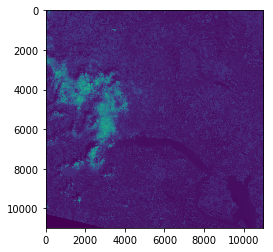

In [69]:
for i in range(1,4):
    fig = plt.imshow(im_list[i])

In [36]:
print(im1)
print('-')
print(im1.squeeze())

[[1866 1806 1666 ... 1462 1459 1461]
 [1823 1759 1678 ... 1475 1468 1490]
 [1754 1734 1717 ... 1482 1470 1493]
 ...
 [   0    0    0 ... 1187 1185 1183]
 [   0    0    0 ... 1184 1188 1186]
 [   0    0    0 ... 1191 1199 1192]]
-
[[1866 1806 1666 ... 1462 1459 1461]
 [1823 1759 1678 ... 1475 1468 1490]
 [1754 1734 1717 ... 1482 1470 1493]
 ...
 [   0    0    0 ... 1187 1185 1183]
 [   0    0    0 ... 1184 1188 1186]
 [   0    0    0 ... 1191 1199 1192]]


In [21]:
filename = '/Users/dustin/CS/Projects/Well_identification/well-sites.gpkg'

gdf = gpd.read_file(r'/Users/dustin/CS/Projects/Well_identification/well-sites.gpkg', layer='well-sites')

In [24]:
buf = gdf.geometry.buffer(0.003)

In [30]:
sq_buf = buf.envelope

In [31]:
sq_buf.to_file("sq_buffer.shp")

In [68]:
file1= '/Users/dustin/CS/Projects/Well_identification/Images/S2B_MSIL1C_20190606T174919_N0207_R141_T13TFN_20190606T211704.SAFE/GRANULE/L1C_T13TFN_A011750_20190606T180048/IMG_DATA/T13TFN_20190606T174919_B03.jp2'
file2 = '/Users/dustin/CS/Projects/Well_identification/Images/S2B_MSIL1C_20190606T174919_N0207_R141_T13UFP_20190606T194941.SAFE/GRANULE/L1C_T13UFP_A011750_20190606T174937/IMG_DATA/T13UFP_20190606T174919_B03.jp2'
merge_files= [file1, file2]
rio_files = []
out_fp = '/Users/dustin/CS/Projects/Well_identification/Images/mosaic.tif'

In [44]:
for i in merge_files:
    src = rio.open(i)
    rio_files.append(src)

In [45]:
mosaic, out_trans = merge(rio_files)

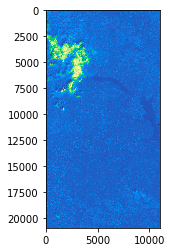

In [47]:
show(mosaic, cmap='terrain')

In [69]:
out_meta = src.meta.copy()
out_meta.update({"driver": "GTiff", "height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans, "crs": "+proj=utm +zone=13 +ellps=WGS84 +datum=WGS84 +units=m +no_defs" } )

In [53]:
src.crs

CRS.from_epsg(32613)

In [70]:
with rio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)